In [1]:
# importações necessárias para o algoritmo
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np
from numpy import concatenate

from matplotlib import pyplot
from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# transforma a data em formato apropriado
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

In [3]:
# carrega os dados do conjunto de dados de entrada, padroniza e os salva no local desejado
def format_dataset(input_path, output_path):
    dataset = read_csv(input_path,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
    dataset.drop('No', axis=1, inplace=True)

    # dá nomes específicos para as colunas
    dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
    dataset.index.name = 'date'

    # substitue todos os valores NA por 0
    dataset['pollution'].fillna(0, inplace=True)

    # exclui as primeiras 24 horas do dataset
    dataset = dataset[24:]

    # mostra apenas as primeiras 5 linhas
    print(dataset.head())

    # salva em arquivo
    dataset.to_csv(output_path)

format_dataset('../data/raw.csv', '../data/pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [4]:
# carrega o conjunto de dados
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset('../data/pollution.csv')
values = dataset.values

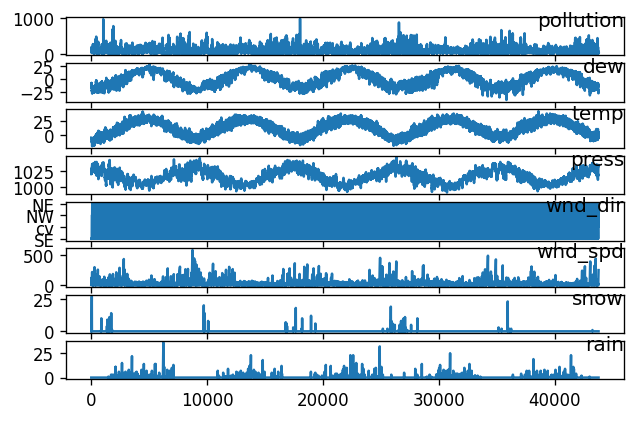

In [5]:
# plota cada coluna como um gráfico
def plot_columns(values):
    groups = range(0,len(values[0]))
    i = 1
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.5, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [6]:
# converte as series para aprendizagem supervisionada
def series_to_supervised(data, n_x=25, n_y=1, dropnan=True):
    n = n_x + 1
    df = DataFrame(data)
    i = 0
    df_len = len(df)
    
    samples = sample = df[0:n]
    df = df.shift(-1)
    df.dropna(inplace=True)
    samples = sample.values
    samples = samples.reshape(1,26,8)
    
    while(i < df_len-1):
        sample = df[0:n]
        if(sample.size == 208):
            df = df.shift(-1)
            df.dropna(inplace=True)
            sample = sample.values
            sample = sample.reshape(1,26,8)
            samples = np.concatenate((samples, sample), axis=0)
        else:
            break
        i += 1
    
    print(df.shape)
    np.save('../data/samples.csv',samples)

(25, 8)


AttributeError: 'NoneType' object has no attribute 'shape'

In [8]:
# codifica os rotulos da coluna 4 em inteiros
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# muda o tipo dos valores para ponto flutuante
values = values.astype('float32')

# normaliza a escala dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#series_to_supervised(scaled)
reframed = np.load('../data/samples.npy')

reframed.shape

(43775, 26, 8)

In [ ]:
# separa o conjunto de dados em subconjuntos de treino e teste
values = reframed
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# separa os subconjuntos de treino e teste em outros subconjuntos
# de entradas e saídas esperadas
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# arquitetura da rede
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(16, activation='relu'))
model.add(Dense(8))
model.compile(loss='mae', optimizer='adam')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
]

# modela a rede
history = model.fit(train_X, 
                    train_y, 
                    epochs=1000, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=True, 
                    callbacks=callbacks)

# plota em grafico o historico de aprendizado e treino
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# faz uma predição
yhat = model.predict(test_X)
print(test_X.shape[0])
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)